<a href="https://colab.research.google.com/github/juliolunamoreno/Ensemble-Model-from-scratch/blob/master/EnsembleClassifier_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This work is intended to explore the advantage of ensemble models as compared with single models in the case of classification tasks

## Ensemble classifiers are models constructed from single classifiers/regressors that combine predictions from models from different sources to make a final prediction. This new model has the main adnatage of reduced variance and thus, makes predictions more stable.



In [0]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import  mode
# model imports
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# dataset generation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [0]:
class EnsembleClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, clfs, weights=None):
        self.clfs = clfs
        self.weights = weights

    def fit(self, X, y):
       
        for clf in self.clfs:
            clf.fit(X, y)

    def predict(self, X):

        self.classes_ = np.asarray([clf.predict(X) for clf in self.clfs])
        if self.weights:
            avg = self.predict_proba(X)

            maj = np.apply_along_axis(lambda x: max(enumerate(x), key=operator.itemgetter(1))[0], axis=1, arr=avg)

        else:
            maj = np.asarray([np.argmax(np.bincount(self.classes_[:,c])) for c in range(self.classes_.shape[1])])

        return maj

    def predict_proba(self, X):

        self.probas_ = [clf.predict_proba(X) for clf in self.clfs]
        avg = np.average(self.probas_, axis=0, weights=self.weights)

        return avg

In [0]:
def Benchmark(models,X,y,scoring='roc_auc',cv=3,return_resultados=True):
    names,roc,cv_min,cv_max,cv_score=[],[],[],[],[]
  
  
    for model in models:
        names.append(str(model)[:str(model).find('(')])
  
    for model in models:
        model.fit(X,y)
        cv_score.append(np.mean(cross_val_score(X=X,y=y,estimator=model,scoring=scoring,cv=cv)))
        cv_min.append(np.min(cross_val_score(X=X,y=y,estimator=model,scoring=scoring,cv=cv)))
        cv_max.append(np.max(cross_val_score(X=X,y=y,estimator=model,scoring=scoring,cv=cv)))
    resultados=pd.DataFrame(data={'CV Score':cv_score,'CV Min':cv_min,'CV max':cv_max},index=names)
    resultados.plot.barh(figsize=(10,5))
    if return_resultados:
        return resultados

# For testing the ensemble model I'm going to use the MNIST dataset
## The first step will be visualizing the data set in order to have an idea od what kind of algorithms can hel for this classification task

In [0]:
df = load_digits()
X = df.data
y = df.target
PCA_=PCA().fit(df.data)
PCAND=PCA_.transform(df.data)

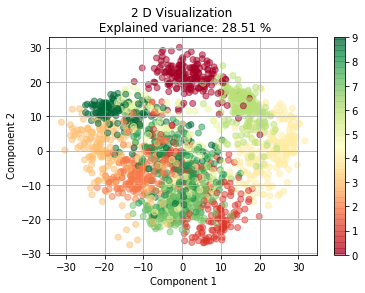

In [13]:
plt.scatter(PCAND[:,0],PCAND[:,1],c=df.target,cmap='RdYlGn',alpha=.5,facecolors='none')
plt.colorbar()
plt.title('2 D Visualization \n Explained variance: %.2f' % (100*PCA_.explained_variance_ratio_.cumsum()[1]) + ' %')
plt.grid()
plt.xlabel('Component 1')
plt.ylabel(' Component 2');

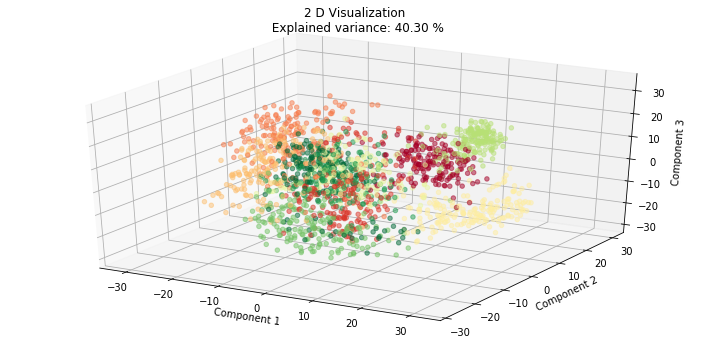

In [14]:
fig = plt.figure(figsize= (10,5))
ax = fig.add_subplot(111, projection= '3d')
ax.scatter(PCAND[:,0],PCAND[:,1],PCAND[:,2], c=df.target, cmap='RdYlGn', alpha= .5,facecolors= 'none')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('2 D Visualization \n Explained variance: %.2f' % (100*PCA_.explained_variance_ratio_.cumsum()[2]) + ' %')
plt.tight_layout();

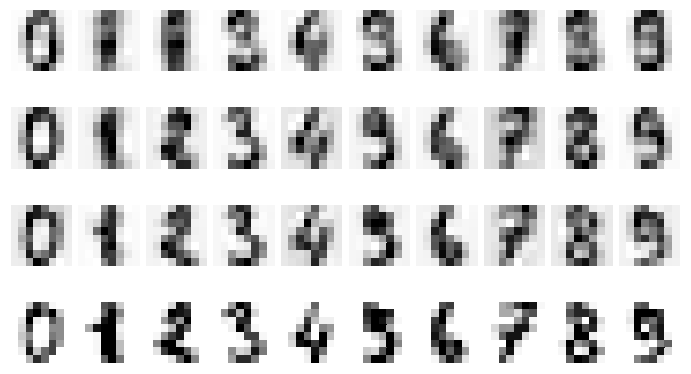

In [15]:
k=1
n_components = [3,10,20,64]
plt.figure(figsize=(12,7))
for row in range(4):
    PCA_ = PCA(n_components= n_components[row],whiten=True).fit(df.data)
    trans = PCA_.transform(df.data)
    proy = PCA_.inverse_transform(trans)
    for col in range(10):
        plt.subplot(4,10,k)
        sns.heatmap(proy[col].reshape(8,8),cmap = 'Greys',square=True, cbar = False)
        plt.subplots_adjust(hspace= .1,wspace = .1)
        plt.xticks([])
        plt.yticks([])
        k+=1

# Modeling

## In this phase 3 different model plus my ensemble model will be tested on cross validation to compare its performace

### Models to be tested:
1. Logistic regression
2. Support vector machine
3. Gaussian Naive Bayes
4. Ensemble

In [0]:
models = [LogisticRegression(solver = 'lbfgs', C = 1,max_iter = 1000),
          SVC(kernel = 'linear'),
          GaussianNB(),
          EnsembleClassifier([LogisticRegression(solver = 'lbfgs', C = 1), SVC(kernel = 'linear'), GaussianNB()])]

# We can see that Ensemble model has reach more stability in term of accuracy

,CV Score,CV Min,CV max
LogisticRegression,0.917661,0.897010,0.946578
SVC,0.943800,0.935216,0.958264
GaussianNB,0.818600,0.799666,0.832215
EnsembleClassifier,0.938797,0.925249,0.959933


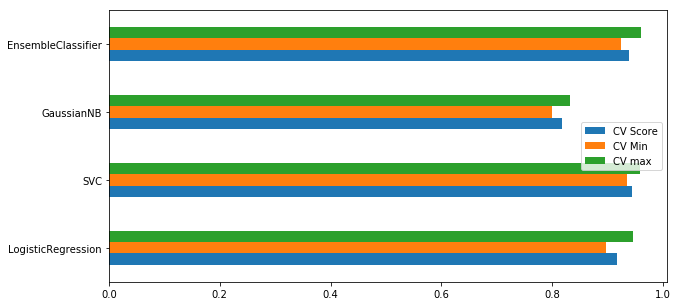

In [61]:
Benchmark(models = models,X = X, y = y, scoring= 'accuracy')